# Predicting bounding boxes around common objects using YOLOv8

First, we start with loading the YOLOv8 model, getting a sample image, and running the model on it to generate bounding boxes around some common objects.

In [1]:
!nvidia-smi

Tue Jun  6 17:28:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
# Pip install method (recommended)
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
from IPython.display import display, Image

Ultralytics YOLOv8.0.20 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


Here we run inference on the image using the YOLOv8 model.

In [4]:
# You can also use the Labelbox Client API to get specific images or an entire
# dataset from your Catalog. Refer to these docs:
# https://labelbox-python.readthedocs.io/en/latest/#labelbox.client.Client.get_data_row

IMAGE_PATH = "https://storage.googleapis.com/labelbox-datasets/image_sample_data/chairs.jpeg"

!wget -v {IMAGE_PATH}

--2023-06-06 17:28:41--  https://storage.googleapis.com/labelbox-datasets/image_sample_data/chairs.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503155 (491K) [image/jpeg]
Saving to: ‘chairs.jpeg’

chairs.jpeg         100%[===================>] 491.36K   640KB/s    in 0.8s    

2023-06-06 17:28:43 (640 KB/s) - ‘chairs.jpeg’ saved [503155/503155]



In [5]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source="{}/{}".format(HOME, os.path.basename(IMAGE_PATH)), conf=0.25)

# print(results[0].boxes.xyxy) # print bounding box coordinates

# print(results[0].boxes.conf) # print confidence scores

#for c in results[0].boxes.cls:
# print(model.names[int(c)]) # print predicted classes

100%|██████████| 6.23M/6.23M [00:00<00:00, 23.3MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


Here we visualize the bounding boxes on the image.

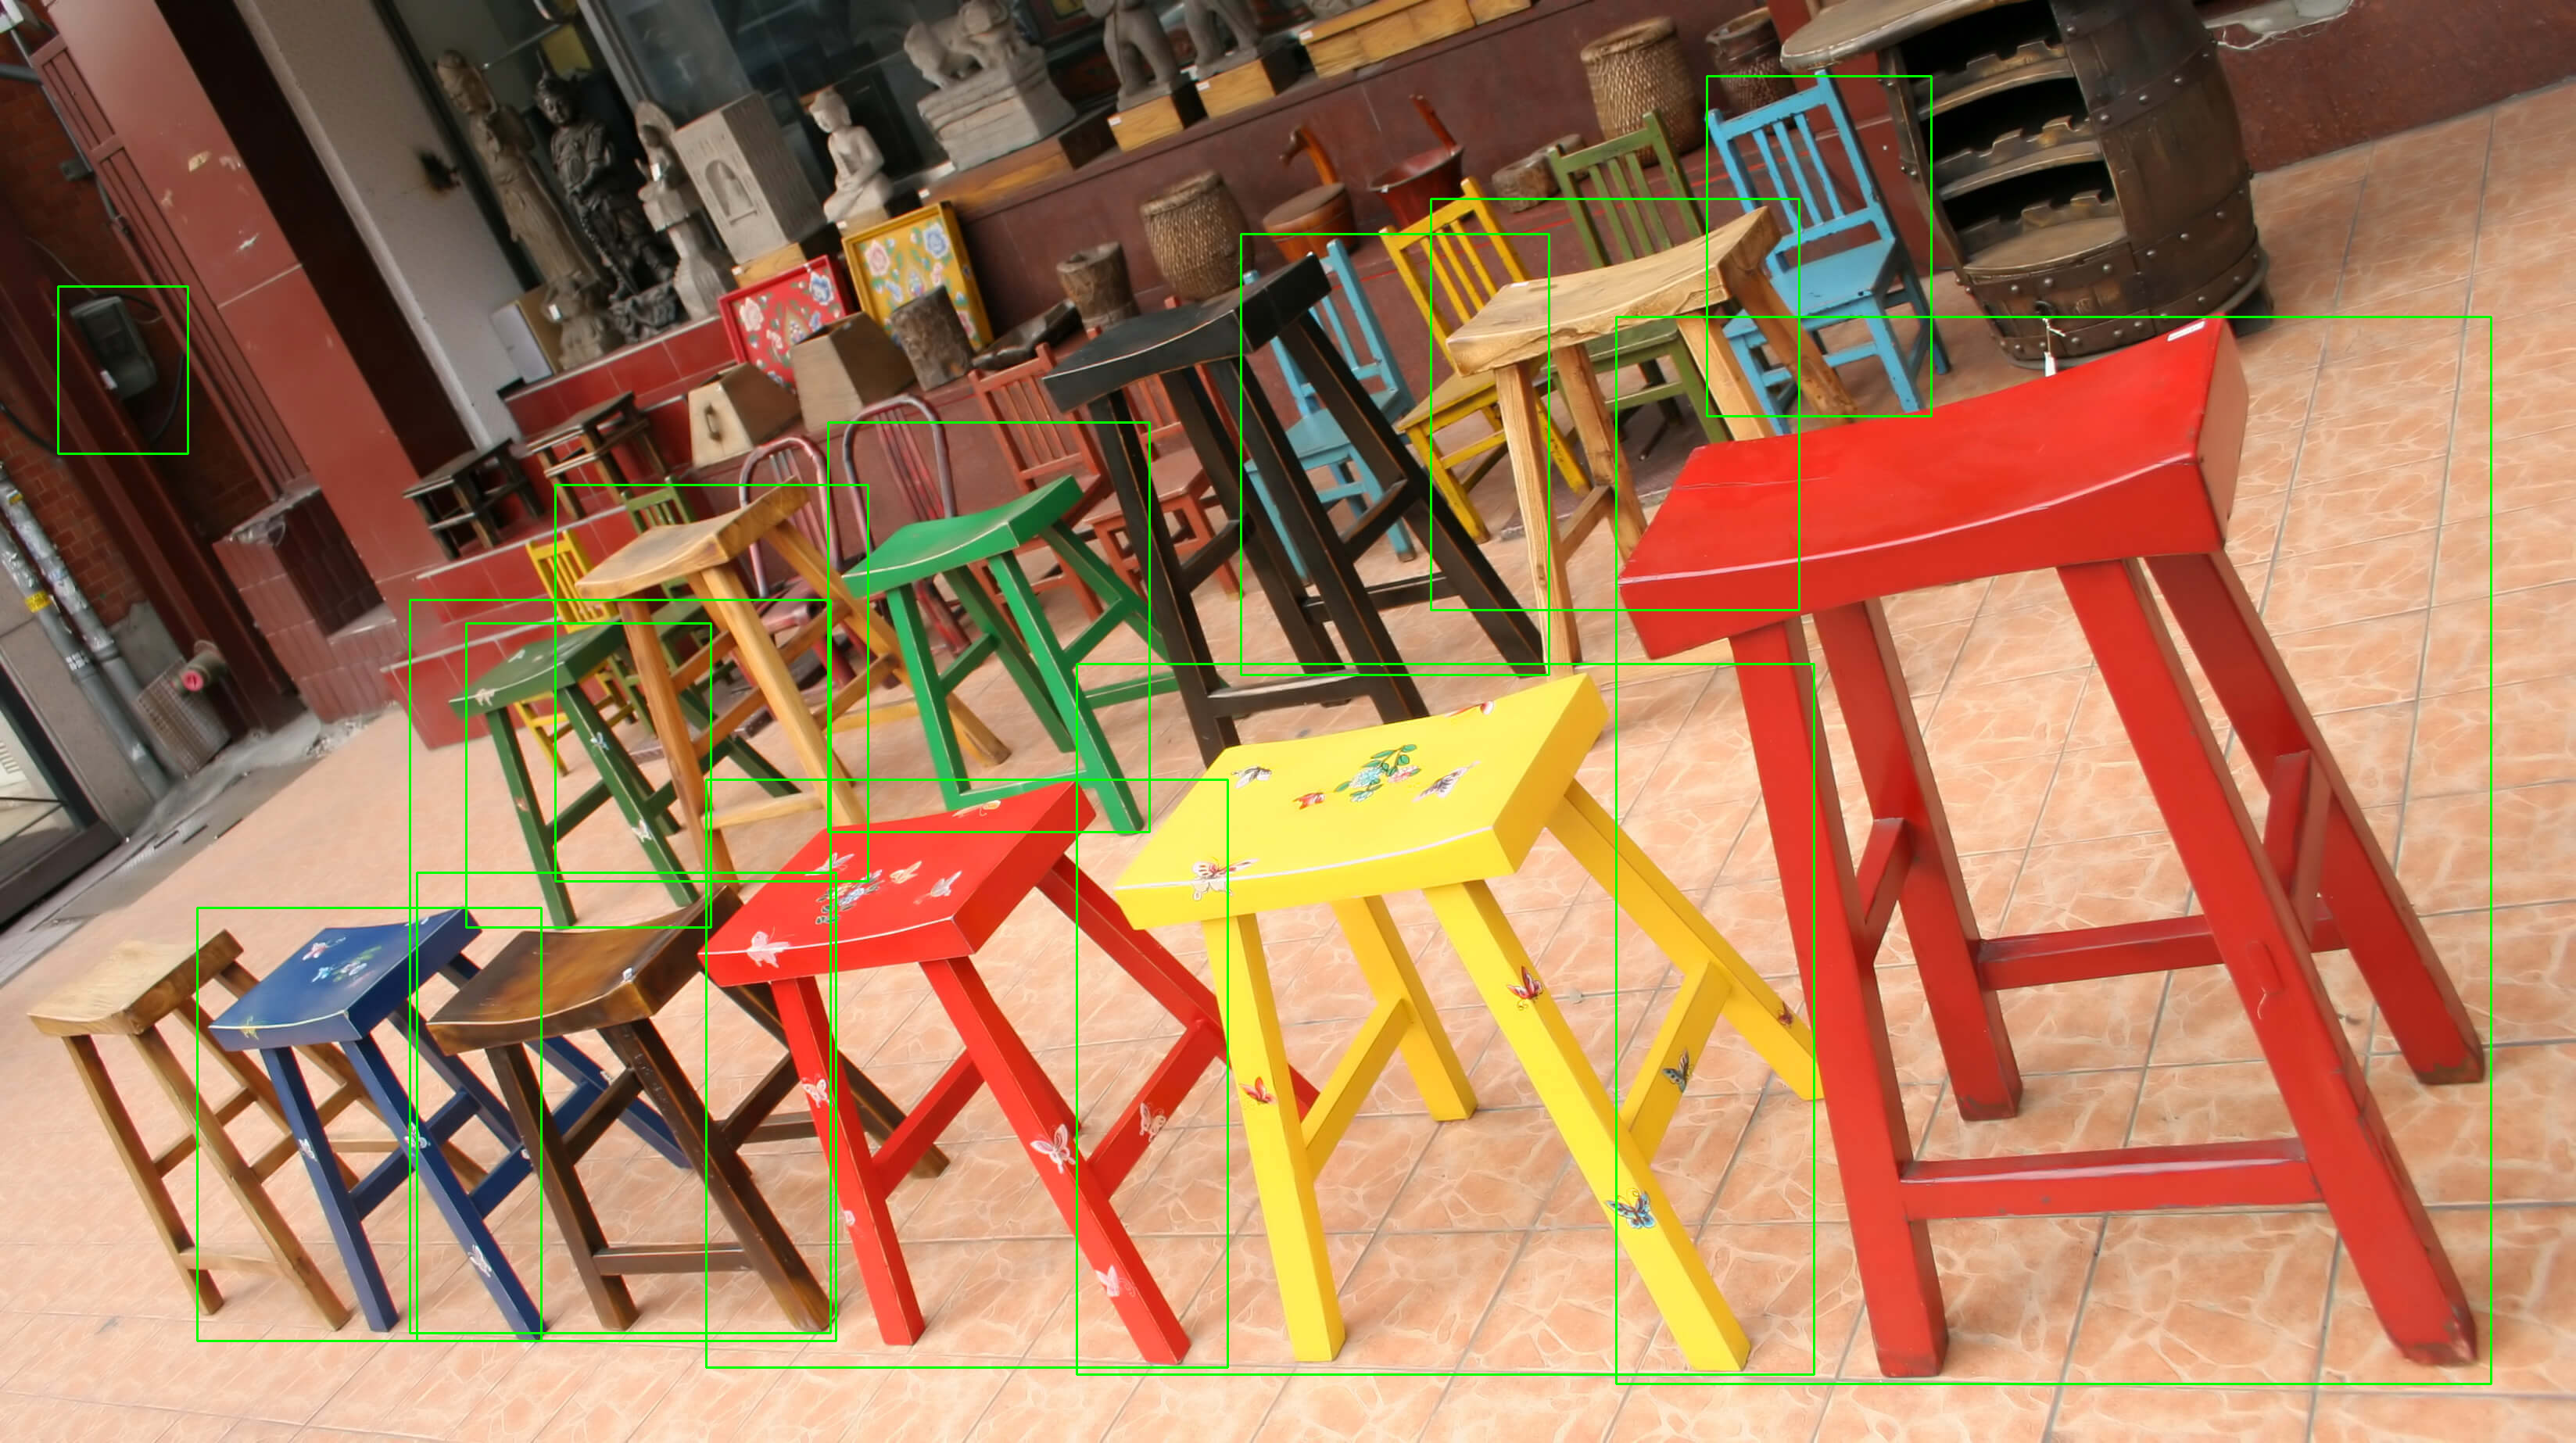

In [6]:
image_bgr = cv2.imread("{}/{}".format(HOME, os.path.basename(IMAGE_PATH)), cv2.IMREAD_COLOR)

for box in results[0].boxes.xyxy:
  cv2.rectangle(image_bgr, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)

cv2_imshow(image_bgr)

# Predicting segmentation masks using Meta's Segment Anything model

Now we load Meta's Segment Anything model and feed the bounding boxes to it, so it can generate segmentation masks within them.

In [7]:
%cd {HOME}

# Download SAM model SDK

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-zb2s6_9h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-zb2s6_9h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=41d9f1881cb654da13e9cc6b5ad4c2bb9533dcaa94634f25d29f24b17df0ae3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nr213pce/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [8]:
# Download SAM model weights

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content
/content/weights
/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [9]:
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [10]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [11]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [12]:
image_bgr = cv2.imread("{}/{}".format(HOME, os.path.basename(IMAGE_PATH)), cv2.IMREAD_COLOR)

transformed_boxes = mask_predictor.transform.apply_boxes_torch(results[0].boxes.xyxy, image_bgr.shape[:2])

mask_predictor.set_image(image_bgr)

masks, scores, logits = mask_predictor.predict_torch(
    boxes = transformed_boxes,
    multimask_output=False,
    point_coords=None,
    point_labels=None
)
masks = np.array(masks.cpu())

# print(masks)
# print(scores)

Here we visualize the segmentation masks drawn on the image.

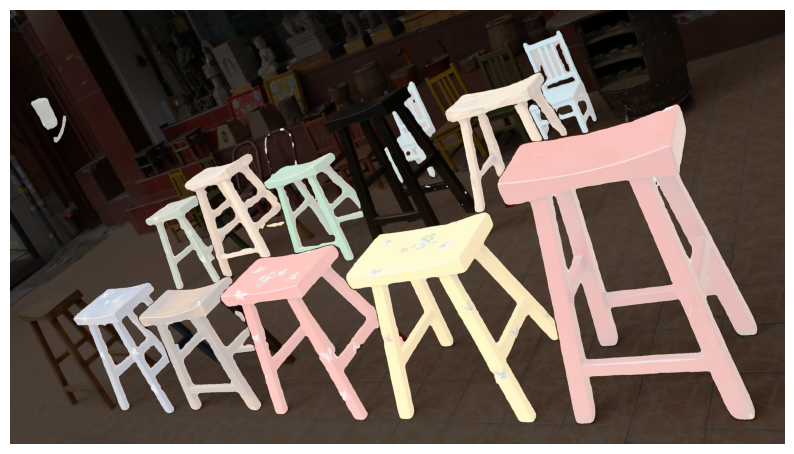

In [13]:
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

final_mask = None
for i in range(len(masks) - 1):
  if final_mask is None:
    final_mask = np.bitwise_or(masks[i][0], masks[i+1][0])
  else:
    final_mask = np.bitwise_or(final_mask, masks[i+1][0])

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.imshow(final_mask, cmap='gray', alpha=0.7)

plt.show()